<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Первая-модель" data-toc-modified-id="Первая-модель-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Первая модель</a></span></li><li><span><a href="#Вторая-модель" data-toc-modified-id="Вторая-модель-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Вторая модель</a></span></li></ul></div>

# Задача

Разработать модель, которая будет классифицировать трафик на нормальный и злонамеренный. При этом модель должна работать максимально качественно, так как цена ошибки может быть очень высока. Оценить качество модели по различным метрикам классификации: precision, recall, f1_score, accuracy.

План проекта:
1. загрузить данные и провести исследование;
2. выполнить предобработку данных;
3. исследовать баланс данных;
4. обучить модель с подбором гиперпараметров;
5. проестировать модель и оценить результат.

In [5]:
import catboost
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import json

from catboost import CatBoostClassifier
from sklearn.metrics import (confusion_matrix, 
                             roc_auc_score,
                             make_scorer,
                             f1_score,
                             precision_score,
                             recall_score,
                             roc_curve,
                             classification_report)

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 80)

# Предварительный анализ данных

In [144]:
# Загрузим данные
df = pd.read_csv('network_traffic_data.csv', sep=',')

In [145]:
# Посмотрим на табличку
df.sample(5)

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
23387,16016,71,2,2,4,12,2,2,2.0,0.0,6,6,6.0,0.0,2.253521e+05,56338.028170,2.366667e+01,2.081666e+00,26,22,49,49.0,0.0,49,49,48,48.0,0.00,48,48,0,0,0,0,48,40,28169.014000,28169.014000,2,6,3.6,2.191,4.8,0,0,0,1,0,0,0,0,1,4.5,2.0,6.0,48,0,0,0,0,0,0,2,4,2,12,1024,0,1,24,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
267403,80,12107687,5,0,30,0,6,6,6.0,0.0,0,0,0.0,0.0,2.477765e+00,0.412961,3.026922e+06,6.052484e+06,12100000,1,12100000,3026921.8,6052483.5,12100000,1,0,0.0,0.00,0,0,0,0,0,0,100,0,0.412961,0.000000,6,6,6.0,0.000,0.0,0,0,0,0,1,0,0,0,0,7.2,6.0,0.0,100,0,0,0,0,0,0,5,30,0,0,256,-1,4,20,2040.0,0.0,2040,2040,12100000.0,0.0,12100000,12100000,DDoS
250300,80,100891638,10,6,744,11595,372,0,74.4,156.9,4344,0,1932.0,1755.0,1.222995e+02,0.158586,6.726109e+06,2.570000e+07,99500000,1,101000000,11200000.0,33100000.0,99500000,1,357399,71479.8,102894.95,223964,16,0,0,0,0,336,200,0.099116,0.059470,0,4344,726.0,1349.000,1820333.5,0,0,0,0,1,0,0,0,0,771.0,74.4,1932.0,336,0,0,0,0,0,0,10,744,6,11595,251,235,2,32,10.0,0.0,10,10,99500000.0,0.0,99500000,99500000,DoS Hulk
520046,80,109009241,2,2,16,0,8,8,8.0,0.0,0,0,0.0,0.0,1.467765e-01,0.036694,3.630000e+07,6.290000e+07,109000000,78,109000000,109000000.0,0.0,109000000,109000000,109000000,109000000.0,0.00,109000000,109000000,1,0,0,0,64,64,0.018347,0.018347,0,8,4.8,4.383,19.2,0,1,0,0,1,0,0,0,1,6.0,8.0,0.0,64,0,0,0,0,0,0,2,16,2,0,229,235,1,32,78.0,0.0,78,78,109000000.0,0.0,109000000,109000000,DoS slowloris
132348,53,165,2,2,72,104,36,36,36.0,0.0,52,52,52.0,0.0,1.066667e+06,24242.424240,5.500000e+01,5.524491e+01,113,3,3,3.0,0.0,3,3,49,49.0,0.00,49,49,0,0,0,0,64,64,12121.212000,12121.212000,36,52,42.4,8.766,76.8,0,0,0,0,0,0,0,0,1,53.0,36.0,52.0,64,0,0,0,0,0,0,2,72,2,104,-1,-1,1,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [146]:
# Выведем информацию о данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539616 entries, 0 to 539615
Data columns (total 79 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0    Destination Port             539616 non-null  int64  
 1    Flow Duration                539616 non-null  int64  
 2    Total Fwd Packets            539616 non-null  int64  
 3    Total Backward Packets       539616 non-null  int64  
 4   Total Length of Fwd Packets   539616 non-null  int64  
 5    Total Length of Bwd Packets  539616 non-null  int64  
 6    Fwd Packet Length Max        539616 non-null  int64  
 7    Fwd Packet Length Min        539616 non-null  int64  
 8    Fwd Packet Length Mean       539616 non-null  float64
 9    Fwd Packet Length Std        539616 non-null  float64
 10  Bwd Packet Length Max         539616 non-null  int64  
 11   Bwd Packet Length Min        539616 non-null  int64  
 12   Bwd Packet Length Mean       539616 non-nul

In [147]:
# Вывдедем статистики
df.describe()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,539616.000000,5.396160e+05,539616.000000,539616.000000,5.396160e+05,5.396160e+05,539616.000000,539616.000000,539616.000000,539616.000000,539616.000000,539616.000000,539616.000000,539616.000000,5.391280e+05,5.396160e+05,5.396160e+05,5.396160e+05,5.396160e+05,5.396160e+05,5.396160e+05,5.396160e+05,5.396160e+05,5.396160e+05,5.396160e+05,5.396160e+05,5.396160e+05,5.396160e+05,5.396160e+05,5.396160e+05,539616.000000,539616.0,539616.000000,539616.0,5.396160e+05,5.396160e+05,5.396160e+05,5.396160e+05,539616.000000,539616.000000,539616.000000,539616.000000,5.396160e+05,539616.000000,539616.000000,539616.000000,539616.000000,539616.000000,539616.000000,539616.000000,539616.000000,539616.000000,539616.000000,539616.000000,539616.000000,5.396160e+05,539616.0,539616.0,539616.0,539616.0,539616.0,539616.0,539616.000000,5.396160e+05,539616.000000,5.396160e+05,539616.000000,539616.000000,539616.000000,5.396160e+05,5.396160e+05,5.396160e+05,5.396160e+05,5.396160e+05,5.396160e+05,5.396160e+05,5.396160e+05,5.396160e+05
mean,5563.061394,2.106693e+07,6.119972,5.985495,4.082371e+02,7.999779e+03,169.449966,11.855382,44.681011,59.525095,1675.074384,23.508936,550.037006,697.306414,inf,inf,2.134902e+06,5.264535e+06,1.731840e+07,2.945584e+05,2.075634e+07,4.036797e+06,6.666492e+06,1.720041e+07,1.035760e+06,9.601754e+06,2.028745e+06,2.413091e+06,6.464188e+06,8.147788e+05,0.036747,0.0,0.000056,0.0,-4.593957e+03,-4.290450e+03,7.142149e+04,7.885307e+03,9.609552,1723.695630,276.581177,544.090932,1.112688e+06,0.062524,0.036747,0.000120,0.377765,0.365884,0.060567,0.000056,0.000120,0.643446,305.358765,44.681011,550.037006,-4.593957e+03,0.0,0.0,0.0,0.0,0.0,0.0,6.119972,4.082371e+02,5.985495,7.998768e+03,7564.762311,1277.937053,2.946516,-2.429314e+03,1.154984e+05,4.037570e+04,1.672882e+05,8.983017e+04,1.610155e+07,9.585649e+05,1.687227e+07,1.539150e+07
std,14921.262751,3.812172e+07,345.109317,463.490949,7.478351e+03,1.014442e+06,560.533869,60.961661,150.873880,217.729412,2843.534429,55.198582,869.702147,1255.312166,NaN,NaN,5.824585e+06,1.055110e+07,3.395701e+07,4.269410e+06,3.812106e+07,1.062759e+07,1.391409e+07,3.402154e+07,8.949951e+06,2.807218e+07,9.045625e+06,8.975673e+06,2.192197e+07,7.698887e+06,0.188139,0.0,0.007456,0.0,2.095355e+06,2.076610e+06,2.685287e+05,3.847268e+04,21.551058,2862.902929,416.169617,903.656284,2.468134e+06,0.242105,0.188139,0.010975,0.484829,0.481678,0.238535,0.007456,0.010975,0.634460,457.152955,150.873880,869.702147,2.095355e+06,0.0,0.0,0.0,0.0,0.0,0.0,345.109317,7.478351e+03,463.490949,1.013814e+06,13440.653528,6590.247532,267.510434,1.052329e+06,7.787530e+05,4.347032e+05,1.059626e+06,7.099710e+05,3.315463e+07,6.461275e+06,3.403851e+07,3.295695e+07

Данных достаточно много и формат данных слишком тяжелый. Далее формат числовых признаков будет сжат. Пропусков в данных незначительное количество, тщательная предобработка не требуется. Встречается несоклько столбцов, которые содержат только одно значение 1. Их можно удалить.

# Предобработка данных

Выполним небольшую предобработку данных: удалим неинформативные столбцы, сожмем формат данных, удалим пропуски.

In [148]:
# Удалим пробелы из названия столбцов
df = df.rename(columns=lambda x: x.strip())

In [149]:
# Сохраним названия столбцов для удаления
col_to_drop = ['Bwd PSH Flags',  
               'Bwd URG Flags', 
               'Fwd Avg Bytes/Bulk', 
               'Fwd Avg Packets/Bulk', 
               'Fwd Avg Bulk Rate', 
               'Bwd Avg Bytes/Bulk', 
               'Bwd Avg Packets/Bulk',  
               'Bwd Avg Bulk Rate']

# Удалим столбцы
df.drop(col_to_drop, axis= 1, inplace= True )

In [150]:
# Заменим тип данных на на более легкий
ints = df.select_dtypes(include='int').columns.to_list()
df[ints] = df[ints].astype(np.int32)

In [151]:
# Заменим тип данных на на более легкий
ints = df.select_dtypes(include='float').columns.to_list()
df[ints] = df[ints].astype(np.float32)

In [152]:
# Заполним значения, которые получены в результате деления на 0
df.replace([np.inf, -np.inf], 0, inplace=True)

In [153]:
# Удалим пропуски
df.dropna(inplace=True)

In [154]:
# Посмотрим на результат
df.sample(5)

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Fwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
283556,80,4,2,0,0,0,0,0,0.00,0.00,0,0,0.0,0.000000,0.000000e+00,500000.000000,4.0,0.000000e+00,4,4,4,4.0,0.0,4,4,0,0.000000e+00,0.000000e+00,0,0,0,0,64,0,500000.000000,0.000000,0,0,0.000000,0.000000,0.000000e+00,0,0,0,0,1,0,0,0,0,0.000000,0.00,0.0,64,2,0,0,0,251,-1,0,32,0.0,0.00000,0,0,0.0,0.0,0,0,DoS Hulk
209708,53,117173056,3,3,149,495,60,44,49.66,8.96,261,76,165.0,92.699997,5.496144e+00,0.051206,23400000.0,4.860000e+07,110000000,23905,117000000,58600000.0,73800000.0,111000000,6404777,117000000,5.860000e+07,7.300000e+07,110000000,6898383,0,0,72,96,0.025603,0.025603,44,261,98.300003,82.400002,6.789571e+03,0,0,0,0,0,0,0,0,1,114.699997,49.66,165.0,72,3,149,3,495,-1,-1,2,20,316507.0,349032.15625,563310,69704,58300000.0,73400000.0,110000000,6335073,BENIGN
347936,80,99673831,6,7,365,11595,365,0,60.84,149.00,4344,0,1656.0,1548.000000,1.199914e+02,0.130425,8306152.5,2.870000e+07,99500000,2,99500000,19900000.0,44500000.0,99500000,3,152657,2.544283e+04,5.681066e+04,141059,48,0,0,200,232,0.060196,0.070229,0,4344,854.500000,1344.000000,1.807324e+06,0,0,0,0,1,0,0,0,1,920.000000,60.84,1656.0,200,6,365,7,11595,274,235,1,32,970.0,0.00000,970,970,99500000.0,0.0,99500000,99500000,DoS Hulk
452186,1494,52,1,1,2,6,2,2,2.00,0.00,6,6,6.0,0.000000,1.538462e+05,38461.539062,52.0,0.000000e+00,52,52,0,0.0,0.0,0,0,0,0.000000e+00,0.000000e+00,0,0,0,0,24,20,19230.769531,19230.769531,2,6,3.334000,2.309000,5.333333e+00,0,0,0,1,0,0,0,0,1,5.000000,2.00,6.0,24,1,2,1,6,1024,0,0,24,0.0,0.00000,0,0,0.0,0.0,0,0,PortScan
135611,53,165,2,2,76,164,38,38,38.00,0.00,82,82,82.0,0.000000,1.454546e+06,24242.423828,55.0,9.006664e+01,159,3,3,3.0,0.0,3,3,3,3.000000e+00,0.000000e+00,3,3,0,0,64,40,12121.211914,12121.211914,38,82,55.599998,24.100000,5.808000e+02,0,0,0,0,0,0,0,0,1,69.500000,38.00,82.0,64,2,76,2,164,-1,-1,1,32,0.0,0.00000,0,0,0.0,0.0,0,0,BENIGN


В результате предобработки бул потерян небольшой процент данных - это не должно негативно сказаться на результатах предсказаний.

# Анализ данных

Далее посмотрим на выбросы и проанализируем баланс классов.

Destination Port


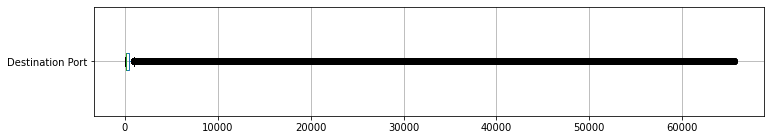

Flow Duration


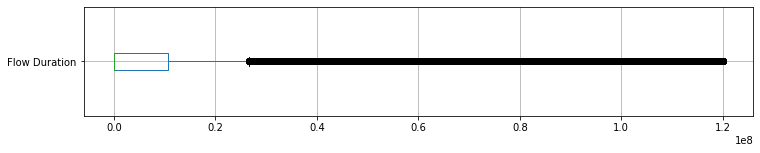

Total Fwd Packets


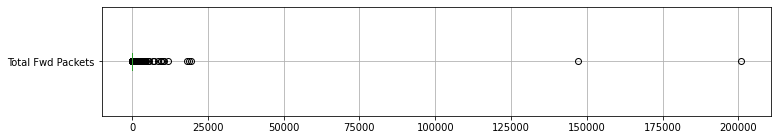

Total Backward Packets


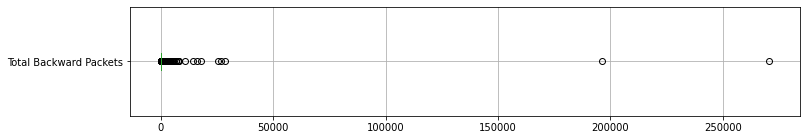

Total Length of Fwd Packets


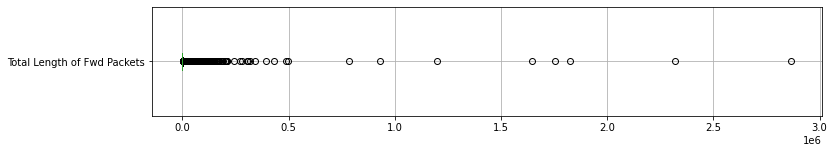

Total Length of Bwd Packets


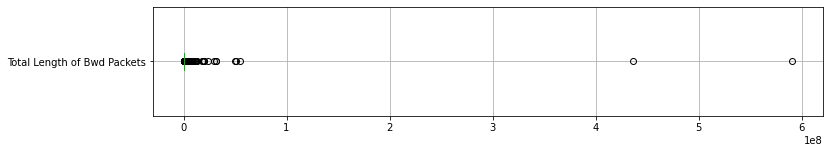

Fwd Packet Length Max


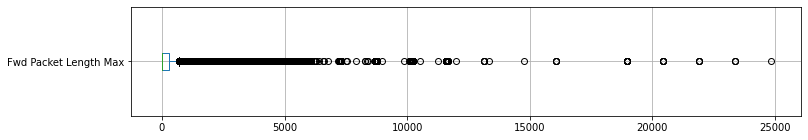

Fwd Packet Length Min


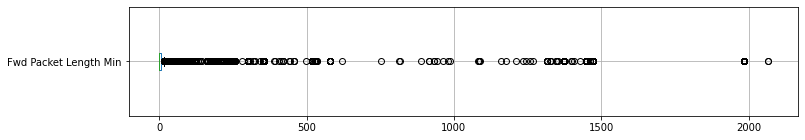

Fwd Packet Length Mean


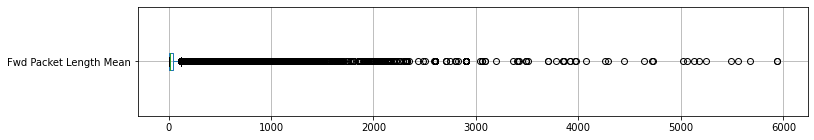

Fwd Packet Length Std


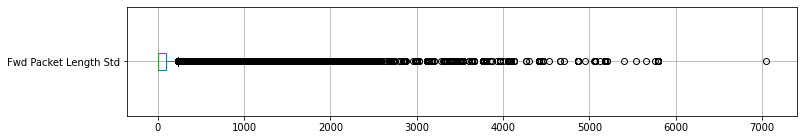

Bwd Packet Length Max


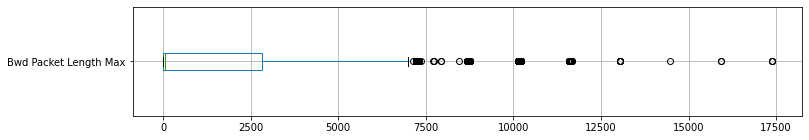

Bwd Packet Length Min


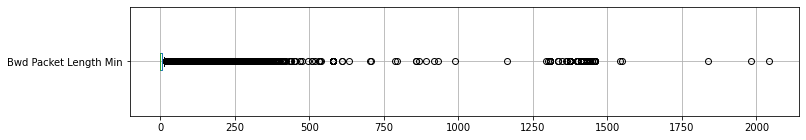

Bwd Packet Length Mean


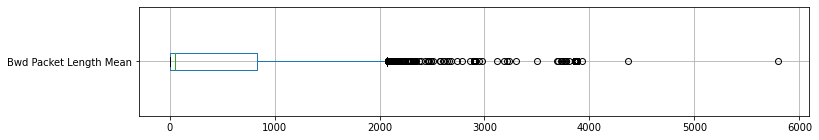

Bwd Packet Length Std


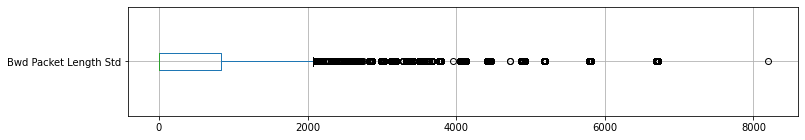

Flow Bytes/s


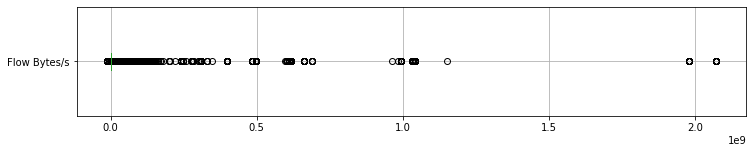

Flow Packets/s


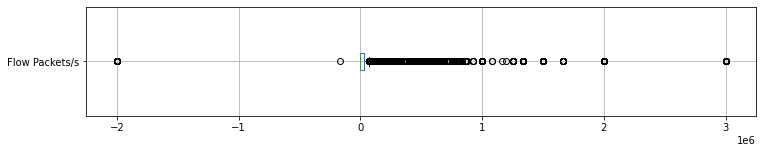

Flow IAT Mean


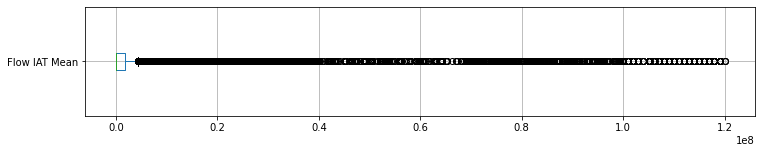

Flow IAT Std


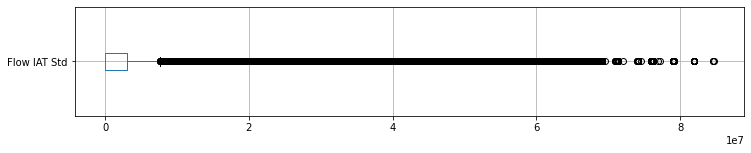

Flow IAT Max


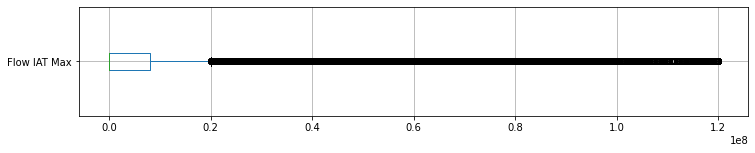

Flow IAT Min


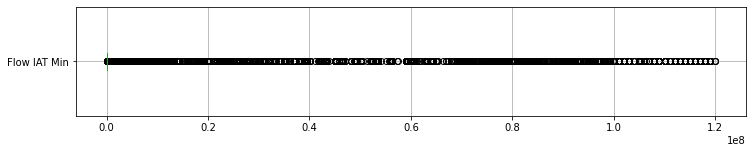

Fwd IAT Total


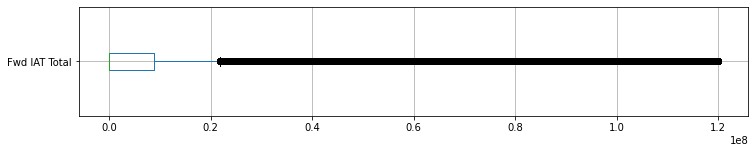

Fwd IAT Mean


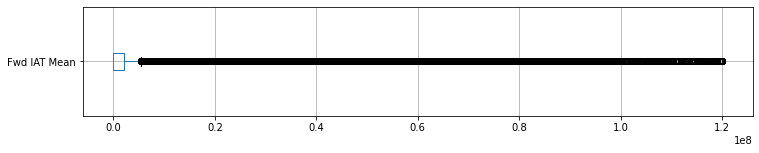

Fwd IAT Std


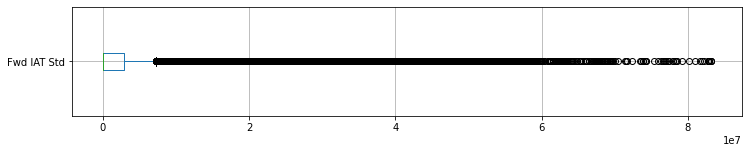

Fwd IAT Max


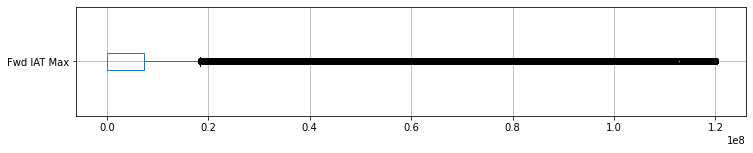

Fwd IAT Min


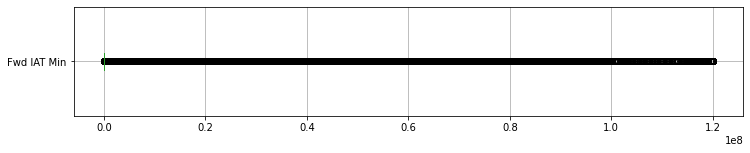

Bwd IAT Total


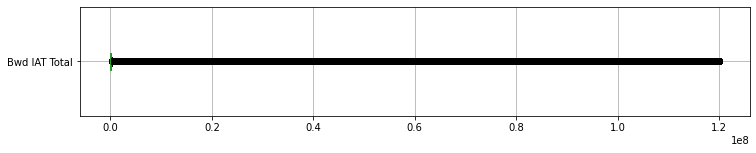

Bwd IAT Mean


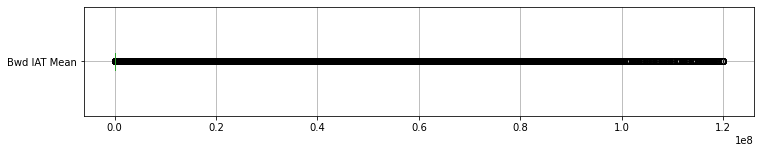

Bwd IAT Std


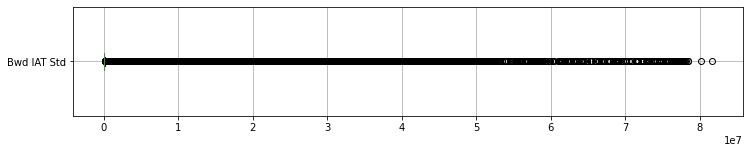

Bwd IAT Max


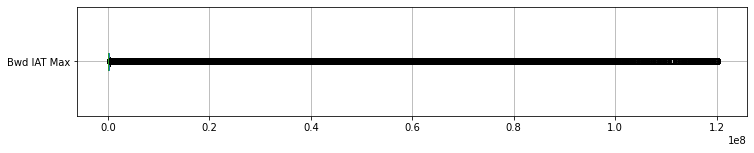

Bwd IAT Min


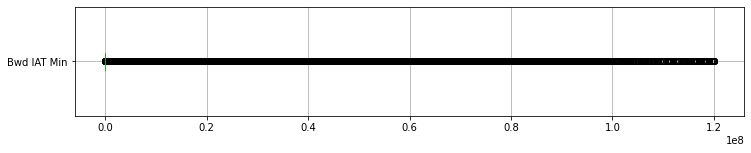

Fwd PSH Flags


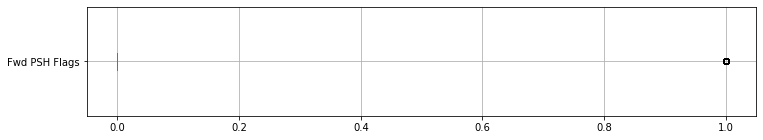

Fwd URG Flags


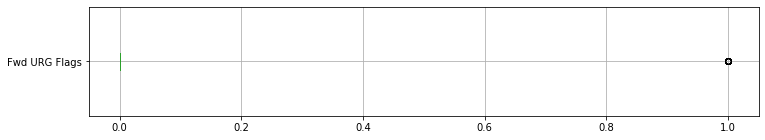

Fwd Header Length


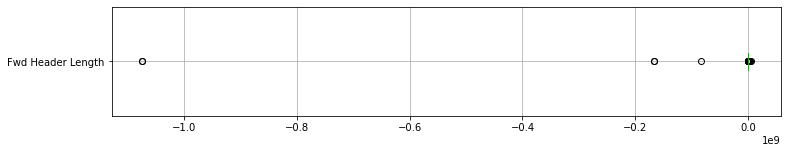

Bwd Header Length


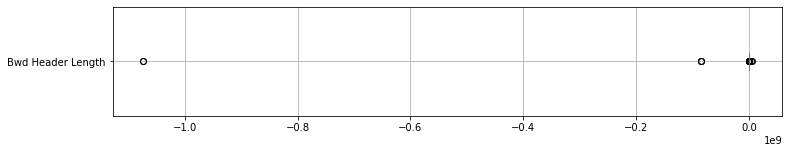

Fwd Packets/s


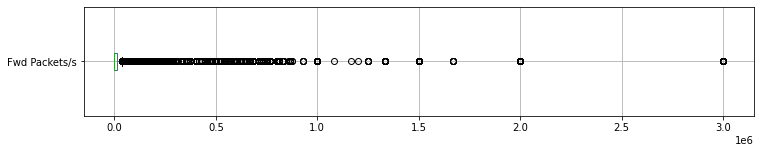

Bwd Packets/s


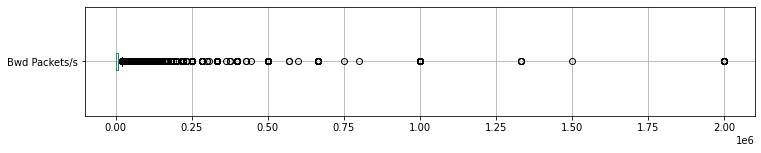

Min Packet Length


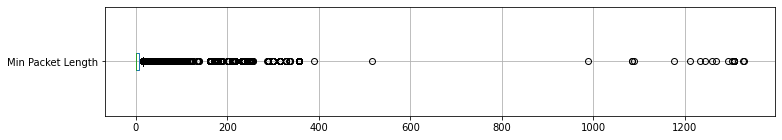

Max Packet Length


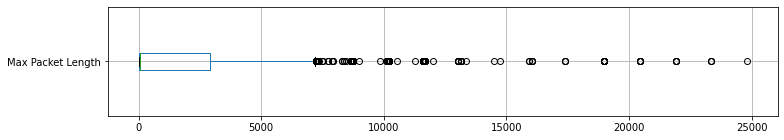

Packet Length Mean


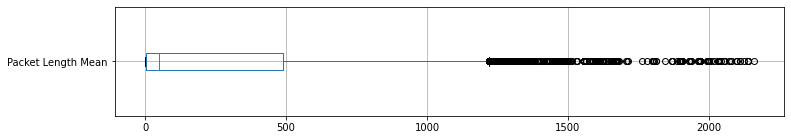

Packet Length Std


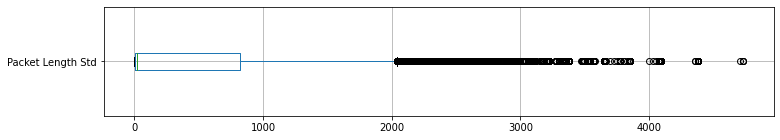

Packet Length Variance


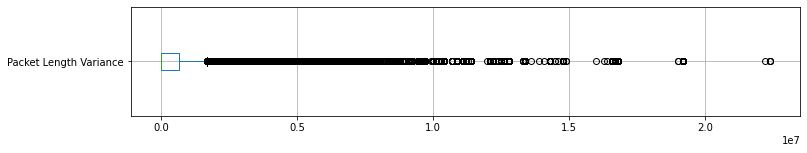

FIN Flag Count


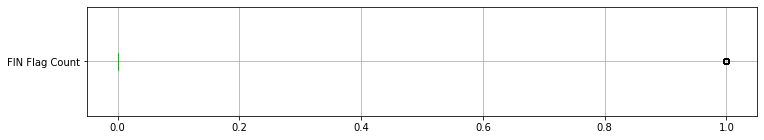

SYN Flag Count


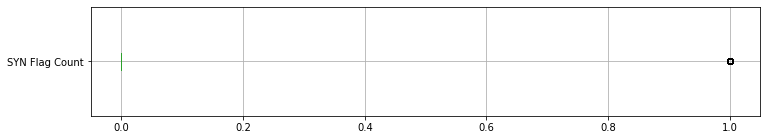

RST Flag Count


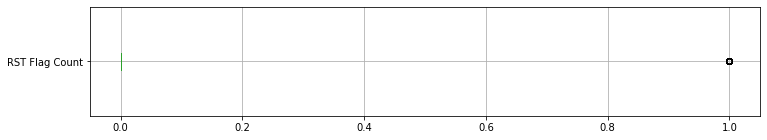

PSH Flag Count


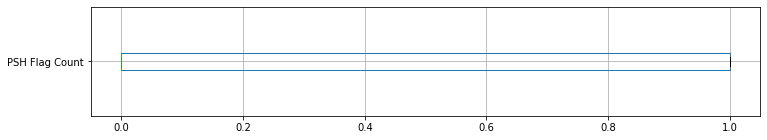

ACK Flag Count


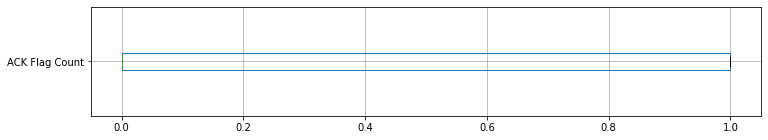

URG Flag Count


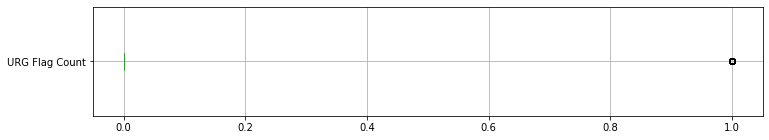

CWE Flag Count


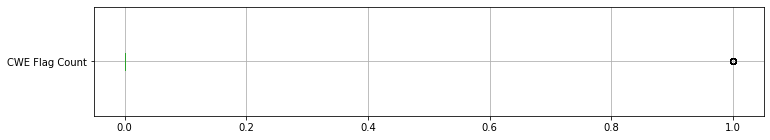

ECE Flag Count


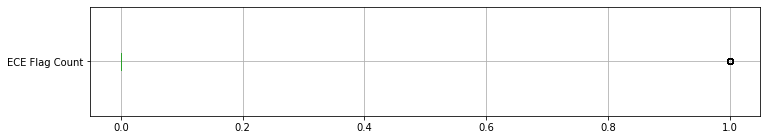

Down/Up Ratio


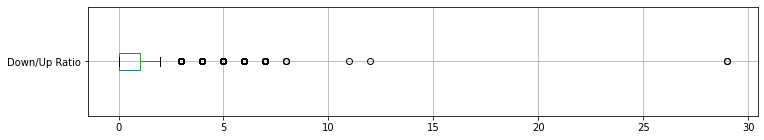

Average Packet Size


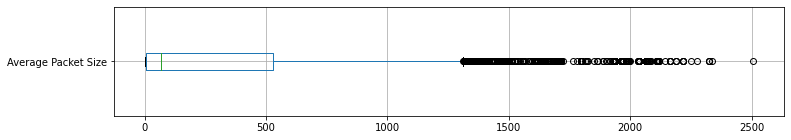

Avg Fwd Segment Size


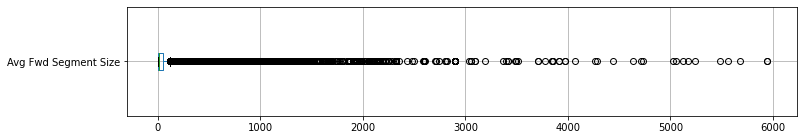

Avg Bwd Segment Size


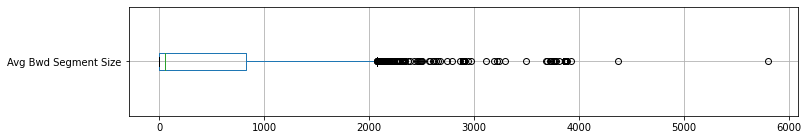

Fwd Header Length.1


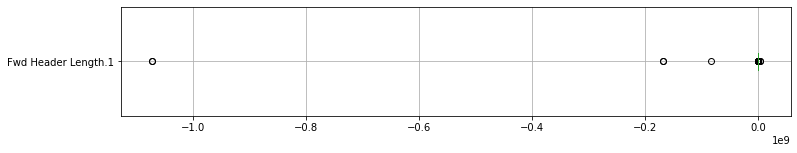

Subflow Fwd Packets


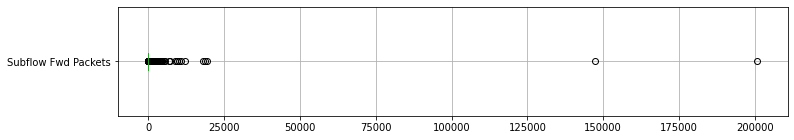

Subflow Fwd Bytes


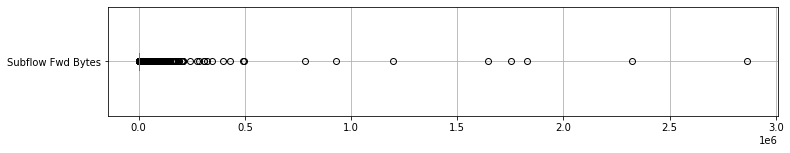

Subflow Bwd Packets


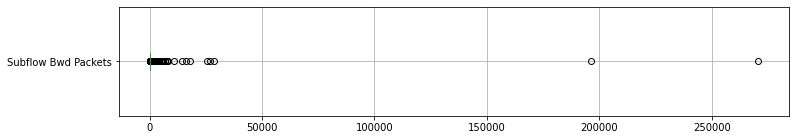

Subflow Bwd Bytes


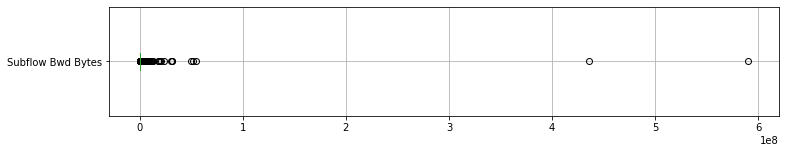

Init_Win_bytes_forward


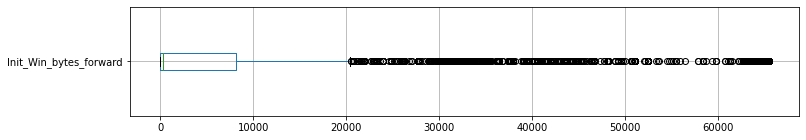

Init_Win_bytes_backward


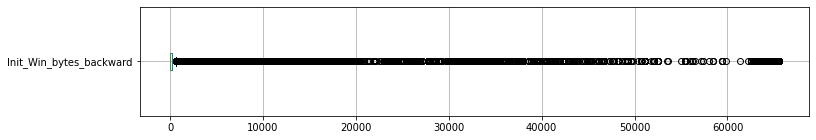

act_data_pkt_fwd


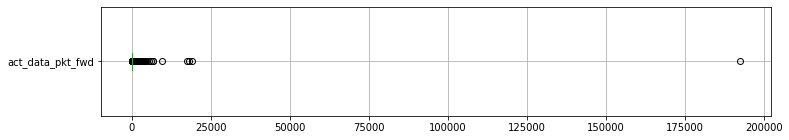

min_seg_size_forward


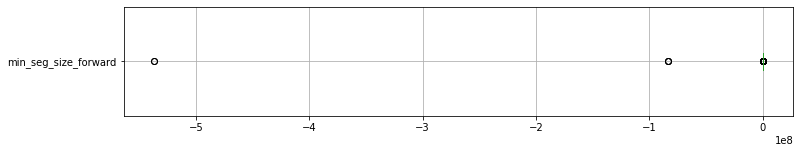

Active Mean


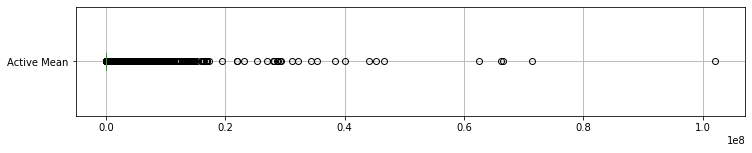

Active Std


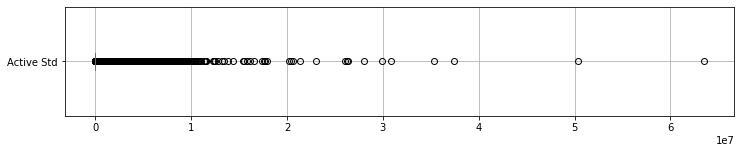

Active Max


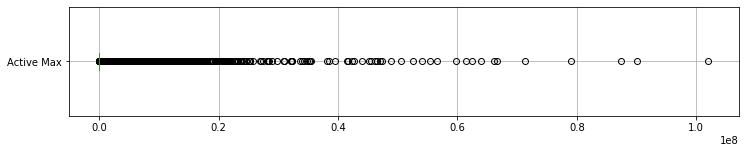

Active Min


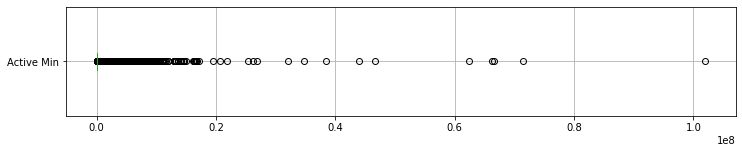

Idle Mean


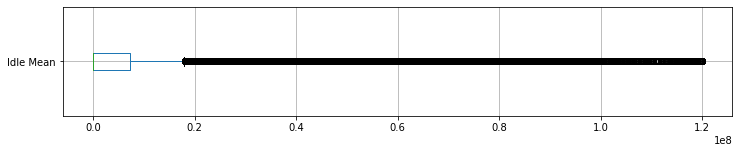

Idle Std


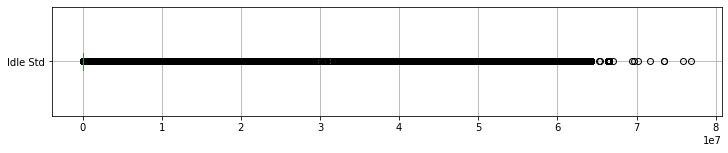

Idle Max


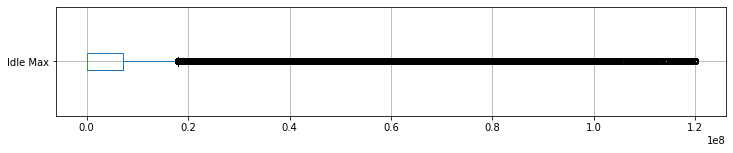

Idle Min


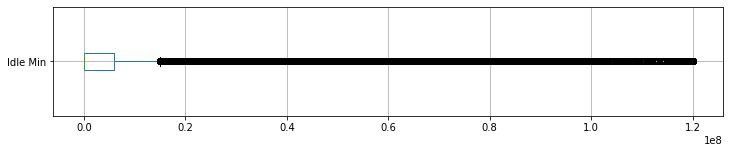

In [106]:
# Вывдедем диаграмму размаха для всех признаков
for column in df.select_dtypes(include=['int', 'float']).columns:
    print(column)
    df.boxplot(column=column, vert=False, figsize=(12,2))
    plt.show()

Выбросы есть практически в каждом столбце. Поскольку данные достаточно разнородные и неизвестно, каким образом получены выбросы, удалять их не следует. Но это необходимо учесть при выборе модели.

In [155]:
# Выведем уникальные названия таргетов
df['Label'].unique()

array(['BENIGN', 'PortScan', 'DoS Hulk', 'DDoS', 'Bot', 'Infiltration',
       'Web Attack � Brute Force', 'Web Attack � XSS',
       'Web Attack � Sql Injection', 'FTP-Patator', 'SSH-Patator',
       'DoS slowloris', 'DoS Slowhttptest', 'DoS GoldenEye', 'Heartbleed'],
      dtype=object)

Судя по названиям, доброкачественный трафик это только BENIGN. Остальное представляет опасность.

Label
BENIGN                        0.445087
DoS Hulk                      0.214285
PortScan                      0.147757
DDoS                          0.119389
DoS GoldenEye                 0.019092
FTP-Patator                   0.014724
SSH-Patator                   0.010938
DoS slowloris                 0.010751
DoS Slowhttptest              0.010200
Bot                           0.003647
Web Attack � Brute Force      0.002795
Web Attack � XSS              0.001209
Infiltration                  0.000067
Web Attack � Sql Injection    0.000039
Heartbleed                    0.000020
Name: proportion, dtype: float64


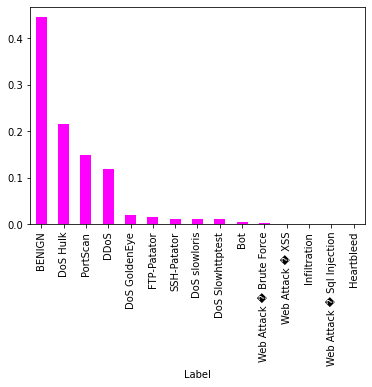

In [156]:
# Относительная частота значений от 0 до 1
class_frequency = df['Label'].value_counts(normalize=True)

# Выведем относительное количество данных в классах
print(class_frequency)

# Для наглядности выведем диаграмму
class_frequency.plot(kind='bar', color='magenta');

Примерно половина трафика не представляет опасности. Создадим новый признак, который отразит классификацию злонамеренный/нормальный трафик, где 1 - атака, 0 - доброкачественный трафик.

In [157]:
# Создадим признак
df['Is_attack'] = np.where(df['Label'] == 'BENIGN', 0, 1)

Is_attack
1    0.554913
0    0.445087
Name: proportion, dtype: float64


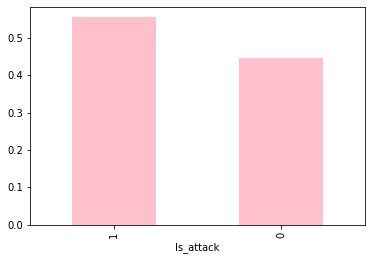

In [158]:
# Относительная частота значений от 0 до 1
class_frequency = df['Is_attack'].value_counts(normalize=True)

# Выведем относительное количество данных в двух классах
print(class_frequency)

# Для наглядности выведем диаграмму
class_frequency.plot(kind='bar', color='pink');

Таким образом, баланс атакующего и нормального трафика практически равный. Это позволит лучше отделить злонамеренный трафик. Далее приступим к разделению выборки и обучению моделей.

# Обучение моделей

Для данной задачи попробуем использовать подход, при котором будет использовано две модели классификации. Первая модель будет предсказывать вредоность трафика - вредоностный или нормальный. Вторая модель будет классифицировать уже только злонамеренный трафик по характеру воздействия. Поскольку баланс классов злономеренный/нормальный трафик практически равный, предполагается, что тако подход будет более эффективным. В перспективе модели можно объединить в один пайплайн, чтобы в один заход получать всю классификацию трафика. Для обеиз подзадач будем использовать catboost как наиболее подходящая модель и не требующая предварительной категоризации данных.

## Первая модель

Как было описано выше, первая модель будет производить бинарную классификацию. Разделим выборку для обучения.

In [172]:
# Разделим выборку
X = df.drop('Is_attack', axis=1)
y = df['Is_attack']

X_train, X_test, y_train, y_test = train_test_split(
        X, y, shuffle=True, test_size=0.25, stratify=y, random_state=1234)

In [173]:
# Для обучения первой модели избавимся от Label
X_train_1 = X_train.drop('Label', axis=1)
y_train_1 = y_train.copy()

In [174]:
# Для обучения первой модели избавимся от Label
X_test_1 = X_test.drop('Label', axis=1)
y_test_1 = y_test.copy()

In [175]:
# Посмотрим на результат деления
print(X_train_1.shape)
print(y_train_1.shape)
print(X_test_1.shape)
print(y_test_1.shape)

(404346, 70)
(404346,)
(134782, 70)
(134782,)


В численных данных много выбросов, нормализуем значения в признаках. Однако, поскольку "деревянные" модели не чувствительны к выбросам, данные можно не нормализовать.

Далее обучим первую модель. Поскольку первоначальная детекция злонамеренного трафика очень важна, для лучших результатов, выполним поиск по сетке.

In [176]:
# Определим модель
cb_model = catboost.CatBoostClassifier(n_estimators=100,
                                       eval_metric='AUC:hints=skip_train~false',
                                       verbose=False)

# Определим параметры для оптимизации
param_search = {'learning_rate': [0.2, 0.3],
                'max_depth': [4, 6],
                'l2_leaf_reg': np.linspace(0, 2, 10)}

# Выполним поиск
cb_result = cb_model.grid_search(param_search,
                                 X_train_1, 
                                 y_train_1, plot=False, refit=True)


bestTest = 0.9998489576
bestIteration = 99

0:	loss: 0.9998490	best: 0.9998490 (0)	total: 11.9s	remaining: 7m 42s

bestTest = 0.9998194298
bestIteration = 67

1:	loss: 0.9998194	best: 0.9998490 (0)	total: 23s	remaining: 7m 16s

bestTest = 0.9998335997
bestIteration = 94

2:	loss: 0.9998336	best: 0.9998490 (0)	total: 34.6s	remaining: 7m 6s

bestTest = 0.9998810261
bestIteration = 99

3:	loss: 0.9998810	best: 0.9998810 (3)	total: 45.5s	remaining: 6m 49s

bestTest = 0.999807327
bestIteration = 99

4:	loss: 0.9998073	best: 0.9998810 (3)	total: 56.7s	remaining: 6m 36s

bestTest = 0.9998828991
bestIteration = 97

5:	loss: 0.9998829	best: 0.9998829 (5)	total: 1m 7s	remaining: 6m 22s

bestTest = 0.9998390372
bestIteration = 99

6:	loss: 0.9998390	best: 0.9998829 (5)	total: 1m 18s	remaining: 6m 10s

bestTest = 0.999864984
bestIteration = 99

7:	loss: 0.9998650	best: 0.9998829 (5)	total: 1m 29s	remaining: 5m 57s

bestTest = 0.9998305552
bestIteration = 99

8:	loss: 0.9998306	best: 0.9998829 (5)

Training has stopped (degenerate solution on iteration 17, probably too small l2-regularization, try to increase it)



bestTest = 0.9991576891
bestIteration = 16

20:	loss: 0.9991577	best: 0.9998829 (5)	total: 3m 45s	remaining: 3m 23s

bestTest = 0.9999308305
bestIteration = 67

21:	loss: 0.9999308	best: 0.9999308 (21)	total: 3m 58s	remaining: 3m 15s

bestTest = 0.9999395928
bestIteration = 99

22:	loss: 0.9999396	best: 0.9999396 (22)	total: 4m 13s	remaining: 3m 7s

bestTest = 0.9999131447
bestIteration = 84

23:	loss: 0.9999131	best: 0.9999396 (22)	total: 4m 30s	remaining: 3m

bestTest = 0.9999297553
bestIteration = 98

24:	loss: 0.9999298	best: 0.9999396 (22)	total: 4m 44s	remaining: 2m 50s

bestTest = 0.9999225881
bestIteration = 99

25:	loss: 0.9999226	best: 0.9999396 (22)	total: 4m 57s	remaining: 2m 40s

bestTest = 0.9999241225
bestIteration = 94

26:	loss: 0.9999241	best: 0.9999396 (22)	total: 5m 11s	remaining: 2m 29s

bestTest = 0.9999321635
bestIteration = 84

27:	loss: 0.9999322	best: 0.9999396 (22)	total: 5m 24s	remaining: 2m 19s

bestTest = 0.9999218195
bestIteration = 99

28:	loss: 0.99992

In [177]:
# Сохраним модель
with open('model_bi.pkl','wb') as f:
    pickle.dump(cb_model,f)

In [178]:
# Сохраним лучшие параметры модели
best_params = cb_model.get_params()

# Вывдем лучший результат
print("Best score:", end=' ')
print(cb_model.best_score_)

# Выведем лучшую модель
print("Best params:", end=' ')
print(best_params)

Best score: {'learn': {'Logloss': 0.0035558078614207687, 'AUC': 0.9999591636064606}}
Best params: {'verbose': False, 'eval_metric': 'AUC:hints=skip_train~false', 'n_estimators': 100, 'depth': 6, 'learning_rate': 0.2, 'l2_leaf_reg': 0.2222222222222222}


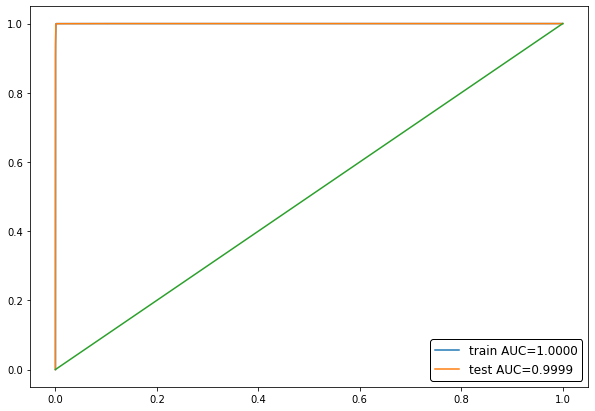

In [179]:
# Получим предсказания в виде вероятностей
y_train_predicted = cb_model.predict_proba(X_train_1)[:, 1]
y_test_predicted = cb_model.predict_proba(X_test_1)[:, 1]

# Посчитаем roc_auc
train_auc = roc_auc_score(y_train, y_train_predicted)
test_auc = roc_auc_score(y_test, y_test_predicted)

# Выведем кривую roc_auc
plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_train_1, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_test_1, y_test_predicted)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

Результаты получились неплохие, модель хорошо предсказала отделила нормальный трафик от вредоностного. Далее классифицируем вредный трафик второй моделью.

## Вторая модель

 Далее подготовим данные для модели, которая будет классифицировать злокачественный трафик. Для этого строки с трафиком BENIGN не будут участовать в обучении и предсказаниях.

In [183]:
# Отфильруем данные
X_train_2 = X_train[X_train['Label'] != 'BENIGN'] 
X_test_2 = X_test[X_test['Label'] != 'BENIGN']

In [184]:
# Сохраним таргеты
y_train_2 = X_train_2['Label']
y_test_2 = X_test_2['Label']

In [185]:
# Удалим таргет из признаков
X_train_2 = X_train_2.drop('Label', axis=1)
X_test_2 = X_test_2.drop('Label', axis=1)

In [186]:
print(X_train_2.shape)
print(y_train_2.shape)
print(X_test_2.shape)
print(y_test_2.shape)

(224377, 70)
(224377,)
(74792, 70)
(74792,)


In [189]:
# Определим параметры модели
model_cb2 = CatBoostClassifier(iterations=100, 
                               depth=6, 
                               learning_rate=0.1,
                               loss_function='MultiClass', 
                               verbose=False)


# Обучим модель
model_cb2.fit(X_train_2, y_train_2, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [190]:
# Сохраним модель
with open('model_multi.pkl','wb') as f:
    pickle.dump(model_cb2,f)

In [194]:
# Получим предсказания на тесте
y_pred = model_cb2.predict(X_test_2)

In [195]:
# Выведем точность
print('Среднаяя точность модели', model_cb2.score(X_train_2, y_train_2).round(2))

Среднаяя точность модели 1.0


In [196]:
# Выведем отчет по классам
print(classification_report(y_test_2, y_pred))

                            precision    recall  f1-score   support

                       Bot       1.00      1.00      1.00       506
                      DDoS       1.00      1.00      1.00     16061
             DoS GoldenEye       1.00      1.00      1.00      2648
                  DoS Hulk       1.00      1.00      1.00     28782
          DoS Slowhttptest       0.99      0.99      0.99      1409
             DoS slowloris       0.99      0.99      0.99      1457
               FTP-Patator       1.00      1.00      1.00      1971
                Heartbleed       1.00      1.00      1.00         1
              Infiltration       1.00      0.60      0.75        10
                  PortScan       1.00      1.00      1.00     19939
               SSH-Patator       1.00      1.00      1.00      1435
  Web Attack � Brute Force       0.70      0.99      0.82       397
Web Attack � Sql Injection       0.00      0.00      0.00         3
          Web Attack � XSS       1.00      0.04

Почти все классы предсказаны с хорошей точностью. Исключение составляют Infiltration, Web Attack � Brute Force, Web Attack � Sql Injection и Web Attack � XSS. Это достаточно малочисленные классы, тренировочных данных для них немного. Интересно, что категория Web Attack XSS предсказывается с хорошей точностью, но полнота почти нулевая. Возможно в этой категории сильный дисбаланс.

# Тестирование моделей

Далее объединим две модели в общий пайплайн. Для этого будет создана функция, принимающая данные о трафике. Первая модель определит злонамеренный ли это трафик, а далее, если это окажется положительный класс, отсортирует по типу атаки. Данные будем подавать в формате json (заготовка под микросервис).

In [232]:
# Создадим тестовую строку в формате json
result = X_test.sample(1).to_json(orient="columns")

In [236]:
# Выполним сохранение и загрузку
save_json = json.dumps(result)
test = json.loads(save_json)

In [237]:
# Зададим функцию для выполнения предсказаний

def attack_prediction(attack_data):
    """Функция принимает данные в формате json.
    Выполняет загрузку модели, преобразование данных
    и выдает предсказание в формате list"""
    
   # Загрузим модели
    with open('model_bi.pkl', 'rb') as fid:
        model_bi = pickle.load(fid)
    
    with open('model_multi.pkl', 'rb') as fid:
        model_multi = pickle.load(fid)
            
    # Загрузим данные
    json_data = json.loads(attack_data)
    df = pd.DataFrame(json_data)
    
    # Удалим признак, указывающий на таргет
    try:
        X = df.drop('Label', axis=1)
    except:
        X = df.copy()
    
    # Сделаем первое предсказание
    predicted_is_attack = model_bi.predict(X)[0]
    
    message = 'BENIGN'
    
    if predicted_is_attack == 1:
        predict_type_attack = model_multi.predict(X)[0]
        
        return predict_type_attack[0]
    
    return message

In [238]:
# Получим результат
attack_prediction(test)

'DDoS'

# Выводы

В результате решения задачи классификации трафика были выполнены следующие пункты и получены результаты:
1. данные загружены и изучены;
2. удалены неинформативные признаки, выполнена предобработка данных;
3. изучен баланс классов;
4. разработана модель, классифицирущая злонамеренный/доброкачественный трафик:
   - модель catboost с параметрами: 'n_estimators': 100, 'depth': 6, 'learning_rate': 0.2, 'l2_leaf_reg': 0.2222222222222222;
   - метрика AUC для тестовой выборки: 0,99;
5. разработана модель, классифцирующая только злонамеренный трафик:
   - модель catboost с параметрами: 'depth': 6, 'learning_rate': 0.1;
   - метрики для классов:
| Тип атаки | precision | recall  |f1-score | support |
|----------|----------|----------|----------|----------|
|                       Bot|       1.00   |   1.00    |  1.00   |    506
|                      DDoS  |     1.00   |   1.00    |  1.00   |  16061
|             DoS GoldenEye|       1.00  |    1.00    |  1.00   |   2648
 |                 DoS Hulk|       1.00   |   1.00   |   1.00   |  28782
  |        DoS Slowhttptest|       0.99   |   0.99   |   0.99   |   1409
  |           DoS slowloris |      0.99  |    0.99   |   0.99  |    1457
  |             FTP-Patator |      1.00  |    1.00   |   1.00  |    1971
  |              Heartbleed |      1.00 |     1.00   |   1.00  |       1
  |            Infiltration |      1.00  |    0.60    |  0.75  |      10
  |                PortScan |      1.00  |    1.00    |  1.00   |  19939
  |             SSH-Patator  |     1.00  |    1.00    |  1.00   |   1435
 | Web Attack � Brute Force |      0.70  |    0.99  |    0.82  |     397
|Web Attack � Sql Injection |      0.00  |    0.00  |    0.00  |       3
|          Web Attack � XSS |      1.00  |    0.04   |   0.08   |    173

6. Модели объеденены в один пайплайн в функцию, которую можно использовать для скрипта с целью вызова из микросервиса.